# Data Driven: Pump It Up (3/3)

**Vilhelm Stiernstedt & Camillo Baratta**
<br>
** Date: 14/03/2018**

** Instructions **
<br>
Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.
<br>
<br>
** Goal **
<br>
Your goal is to predict the operating condition of a waterpoint for each record in the dataset.
The labels in this dataset are simple. There are three possible values:

- functional - the waterpoint is operational and there are no repairs needed
- functional needs repair - the waterpoint is operational, but needs repairs
- non functional - the waterpoint is not operational

**Plan**
1. Import libraries
2. Import data
3. Data description
4. Feature analysis
5. Data cleaning
    - Impute missing values
    - Outlier treatment
6. Feature engineering
    - Transformation
    - Binning
    - New features
7. Feature selection
    - Drop irrelevant features
8. Modelling Preparation
    - One-hot encoding
    - Test/train split
9. Modelling
    - Randomforest model
    - Light GBM
    - KNN
    - LDA
    - LR-OVR (OneVsAll)
    - Stacked Model
10. Submission

<br>
** Notebooks used in project:**
<br>
The different steps are distrubuted over 3 notebooks:
1. Data Analysis - step 1-4 (Pump_Data_Analysis)
2. Data Preparation - steps 5-8 (Pump_Data_Preparation)
3. Data Modelling - steps 9-10 (Pump_Models)

In [1]:
# Import libaries
import datetime as dt
import itertools
# conda install -c conda-forge lightgbm 
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# conda install mlxtend --channel conda-forge
from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RandomizedSearchCV
import sklearn.pipeline
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import warnings

# Pandas settings
pd.set_option('display.max_columns', 100)

# Plot settings
%matplotlib inline

# Warning settings -> suppress depreciation warnings for lgbm model
warnings.filterwarnings('ignore')

In [2]:
# Data Processing
# Import data
train_data = pd.read_csv("data/train_clean.csv", sep=",")
test_data = pd.read_csv("data/test_clean.csv", sep=",")
train_labels = pd.read_csv("data/train_set_labels.csv", sep=",")

# Set id as index
train_data.set_index('id', inplace=True)
test_data.set_index('id', inplace=True)
train_labels.set_index('id', inplace=True)

In [3]:
# Factorize train_labels
target_labels = pd.factorize(train_labels.status_group)[0]

In [4]:
# Save feature names
feature_list = list(train_data.columns)

# Convert to numpy arrays
target_labels_np = np.array(target_labels)
train_data_np = np.array(train_data)
test_data_np = np.array(test_data)

In [5]:
# Split train_data into train(x) and validation(y) split
train_features, validation_features, train_labels, validation_labels = \
    train_test_split(train_data_np, target_labels_np, test_size=0.25, random_state=42)

## 9. Modelling 

- Randomforest model
- Light GBM
- KNN
- LDA
- LR-OVR (OneVsAll)
- Stacked Model

### Random Forest Pipline
In this pipline we will not only try to hyperparameter tune but also incorporate feature selection by allowing the random forest to choose different number of best features.

In [6]:
# number of features inc. dummy features
len(feature_list)

159

#### Set up Pipline

In [8]:
# define number of features to select
select = sklearn.feature_selection.SelectKBest(k=100)

# define rf model
clf = RandomForestClassifier()

# define steps of pipline                  
steps = [('feature_selection', select),
        ('my_classifier', clf)]

# define pipline                  
rf_pipeline = sklearn.pipeline.Pipeline(steps)

# split train_data into train(x) and validation(y) split          
X_train, X_test, y_train, y_test = train_test_split(train_data_np, target_labels_np, test_size=0.30, random_state=42)

# fit your pipeline on X_train and y_train
rf_pipeline.fit(X_train, y_train)

# call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = rf_pipeline.predict(X_test)

# test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report(y_test, y_prediction)

# view the report
print(report)

             precision    recall  f1-score   support

          0       0.80      0.87      0.83      9724
          1       0.81      0.77      0.79      6803
          2       0.50      0.33      0.40      1293

avg / total       0.78      0.79      0.78     17820



#### Hyperparameter Tuning - 1st Round

In [92]:
# Define parameters for random search
parameters = dict(feature_selection__k=[10, 20, 50, 100, 159], 
                  my_classifier__n_estimators=[100, 200, 300, 500],
                  my_classifier__max_depth=[10, 20, 50, 70, 100],
                  my_classifier__min_samples_split=[2, 5, 10, 20, 30, 50],
                  my_classifier__min_samples_leaf=[2, 5, 10, 20, 30, 50],
                  my_classifier__bootstrap=[True, False])

rf_pipeline_rand_cv = RandomizedSearchCV(estimator=rf_pipeline, param_distributions=parameters,
                                  n_iter=20, cv=3, verbose=1, random_state=42)

# Fit the random search model
rf_pipeline_rand_cv.fit(X_train, y_train);

# Make predictions
y_predictions = rf_pipeline_rand_cv.predict(X_test)

# Define reporting metric
report = sklearn.metrics.classification_report(y_test, y_predictions)

# View report output
print(report)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 12.9min finished


             precision    recall  f1-score   support

          0       0.81      0.90      0.85      9724
          1       0.84      0.78      0.81      6803
          2       0.58      0.32      0.42      1293

avg / total       0.80      0.81      0.80     17820



In [93]:
# Create confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_predictions))

,0,1,2
0,8707,801,216
1,1416,5304,83
2,678,198,417


In [95]:
# get best parameters from rand serach
rf_pipeline_rand_cv.best_params_

{'feature_selection__k': 100,
 'my_classifier__bootstrap': False,
 'my_classifier__max_depth': 50,
 'my_classifier__min_samples_leaf': 2,
 'my_classifier__min_samples_split': 5,
 'my_classifier__n_estimators': 300}

#### Hyperparameter Tuning - 2nd Round

In [96]:
# Define parameters for random search
parameters = dict(feature_selection__k=[70, 85, 100, 115, 130], 
                  my_classifier__n_estimators=[250, 300, 350, 400],
                  my_classifier__max_depth=[35, 40, 50, 55, 60],
                  my_classifier__min_samples_split=[2, 3, 4],
                  my_classifier__min_samples_leaf=[3, 4, 5, 6, 7],
                  my_classifier__bootstrap=[True, False])

rf_pipeline_rand_cv = RandomizedSearchCV(estimator=rf_pipeline, param_distributions=parameters,
                                  n_iter=20, cv=3, verbose=1, random_state=42)

# Fit the random search model
rf_pipeline_rand_cv.fit(X_train, y_train);

# Make predictions
y_predictions = rf_pipeline_rand_cv.predict(X_test)

# Define reporting metric
report = sklearn.metrics.classification_report(y_test, y_predictions)

# View report output
print(report)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 96.5min finished


             precision    recall  f1-score   support

          0       0.80      0.91      0.85      9724
          1       0.85      0.77      0.80      6803
          2       0.62      0.28      0.38      1293

avg / total       0.80      0.81      0.80     17820



In [97]:
# Create confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_predictions))

,0,1,2
0,8816,757,151
1,1512,5225,66
2,739,198,356


In [98]:
# get best parameters from rand serach
rf_pipeline_rand_cv.best_params_

{'feature_selection__k': 115,
 'my_classifier__bootstrap': False,
 'my_classifier__max_depth': 40,
 'my_classifier__min_samples_leaf': 3,
 'my_classifier__min_samples_split': 4,
 'my_classifier__n_estimators': 300}

#### Hyperparameter Tuning - 3rd Round

In [10]:
# Define parameters for random search
parameters = dict(feature_selection__k=[105, 110, 115, 120, 125], 
                  my_classifier__n_estimators=[290, 300, 310, 320],
                  my_classifier__max_depth=[35, 38, 40, 42, 45],
                  my_classifier__min_samples_split=[3, 4, 5, 6],
                  my_classifier__min_samples_leaf=[2, 3, 4, 5],
                  my_classifier__bootstrap=[True, False])

rf_pipeline_rand_cv = RandomizedSearchCV(estimator=rf_pipeline, param_distributions=parameters,
                                  n_iter=20, cv=3, verbose=1, random_state=42)

# Fit the random search model
rf_pipeline_rand_cv.fit(X_train, y_train);

# Make predictions
y_predictions = rf_pipeline_rand_cv.predict(X_test)

# Define reporting metric
report = sklearn.metrics.classification_report(y_test, y_predictions)

# View report output
print(report)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 21.9min finished


             precision    recall  f1-score   support

          0       0.81      0.90      0.85      9724
          1       0.84      0.78      0.81      6803
          2       0.59      0.33      0.42      1293

avg / total       0.81      0.81      0.80     17820



In [11]:
# Create confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_predictions))

,0,1,2
0,8713,800,211
1,1395,5330,78
2,672,200,421


In [12]:
# get best parameters from rand serach
rf_pipeline_rand_cv.best_params_

{'feature_selection__k': 110,
 'my_classifier__bootstrap': False,
 'my_classifier__max_depth': 40,
 'my_classifier__min_samples_leaf': 2,
 'my_classifier__min_samples_split': 4,
 'my_classifier__n_estimators': 320}

In [25]:
# Merge feature names and importance score into df
features_names = pd.DataFrame(feature_list)
rf_feature_importance_score = pd.DataFrame(rf_pipeline.steps[1][1].feature_importances_)
rf_feature_importance = pd.concat([features_names, rf_feature_importance_score], axis=1)

# Assign columns names
new_cols = ['rf_feature', 'rf_importance']
rf_feature_importance.columns = new_cols

# Sort values by importance and show top 20
rf_feature_importance = rf_feature_importance.sort_values('rf_importance', ascending=False).head(20)
# insert ranking score
rf_feature_importance['rank'] = range(1, 21)
# set rank as index
rf_feature_importance.set_index('rank', inplace=True)

rf_feature_importance

,rf_feature,rf_importance
rank,,
1,gps_height,0.106222
2,permit_False.1,0.084643
3,population_log,0.074575
4,well_age,0.063211
5,long_simple,0.057757
6,lat_simple,0.055716
7,amount_tsh_log,0.035437
8,scheme_management_Company,0.028696
9,recorded_month,0.023704


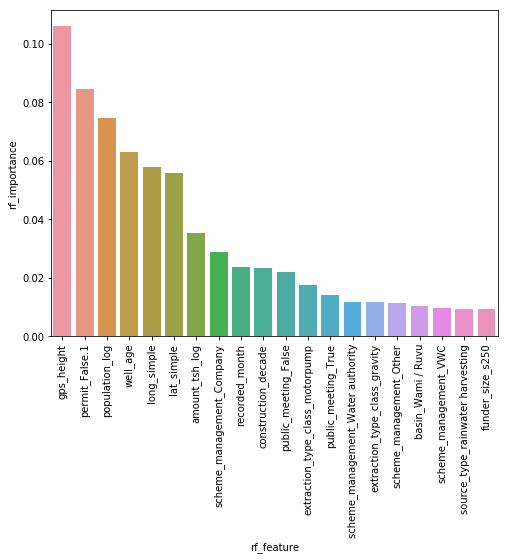

In [30]:
# Plot rf feature importance
# Set plot size
fig, ax = plt.subplots(figsize=(8, 6))

# Plot importance with correct lables
g = sns.barplot(data=rf_feature_importance, x='rf_feature', y='rf_importance')
g.set_xticklabels(rf_feature_importance.rf_feature, rotation=90);

A quite good split of importance over a few features. Amount_tsh_log stll contains incorrect values, thus we ran model without feature, however model lost accurancy and we keep it.

#### Prediction of final data for sub-submission

In [15]:
# Fit the random search model
#rf_final_pipeline = rf_pipeline_rand_cv.best_estimator_.fit(train_data_np, target_labels_np);

# Make predictions
#rf_final_predictions = rf_final_pipeline.predict(test_data_np)


## Light GBM

#### Set up LGBM Pipline

In [31]:
# define number of features to select
select = sklearn.feature_selection.SelectKBest(k=100)

# define rf model
clf2 = lgb.LGBMClassifier()

# define steps of pipline                  
steps = [('feature_selection', select),
        ('my_classifier', clf2)]

# define pipline                  
lgbm_pipeline = sklearn.pipeline.Pipeline(steps)

# split train_data into train(x) and validation(y) split          
X_train, X_test, y_train, y_test = train_test_split(train_data_np, target_labels_np, test_size=0.30, random_state=42)

# fit your pipeline on X_train and y_train
lgbm_pipeline.fit(X_train, y_train)

# call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = lgbm_pipeline.predict(X_test)

# test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report(y_test, y_prediction)

# view the report
print(report)

             precision    recall  f1-score   support

          0       0.75      0.92      0.83      9724
          1       0.84      0.70      0.76      6803
          2       0.65      0.18      0.28      1293

avg / total       0.78      0.78      0.76     17820



#### Hyperparameter Tuning - 1st Round

In [22]:
# Define parameters for random search
parameters = dict(feature_selection__k=[10, 20, 50, 100, 159],
                    my_classifier__n_estimators=[100, 200, 300],
                    my_classifier__objective='multiclass_ovr',
                    my_classifier__metric='multi_logloss',
                    my_classifier__learning_rate=[0.05, 0.1, 0.15],
                    my_classifier__max_depth=[4, 6, 8, -1],
                    my_classifier__num_leaves=[15, 25, 50],
                    my_classifier__subsample=[1, 2, 3],
                    my_classifier__feature_fraction=[0.4, 0.8, 0.12],
                    my_classifier__bagging_fraction=[0.4, 0.8, 0.12],
                    my_classifier__bagging_freq=[5, 10, 17])

lgbm_pipeline_rand_cv = RandomizedSearchCV(estimator=lgbm_pipeline, param_distributions=parameters,
                                  n_iter=20, cv=3, verbose=1, random_state=42)

# Fit the random search model
lgbm_pipeline_rand_cv.fit(X_train, y_train);

# Make predictions
y_predictions = lgbm_pipeline_rand_cv.predict(X_test)

# Define reporting metric
report = sklearn.metrics.classification_report(y_test, y_predictions)

# View report output
print(report)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.9min finished


             precision    recall  f1-score   support

          0       0.79      0.90      0.84      9724
          1       0.83      0.75      0.79      6803
          2       0.60      0.27      0.37      1293

avg / total       0.79      0.80      0.79     17820



In [23]:
# Create confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_predictions))

,0,1,2
0,8746,813,165
1,1611,5125,67
2,731,215,347


In [25]:
# get best parameters from rand serach
lgbm_pipeline_rand_cv.best_params_

{'feature_selection__k': 159,
 'my_classifier__bagging_fraction': 0.4,
 'my_classifier__bagging_freq': 5,
 'my_classifier__feature_fraction': 0.8,
 'my_classifier__learning_rate': 0.1,
 'my_classifier__max_depth': -1,
 'my_classifier__metric': 's',
 'my_classifier__n_estimators': 200,
 'my_classifier__num_leaves': 50,
 'my_classifier__objective': 'u',
 'my_classifier__subsample': 1}

#### Hyperparameter Tuning - 2nd Round

In [33]:
# Define parameters for random search
parameters = dict(feature_selection__k=[130, 140, 150, 159],
                    my_classifier__n_estimators=[150, 200, 250],
                    my_classifier__objective='multiclass',
                    my_classifier__metric='multi_logloss',
                    my_classifier__learning_rate=[0.08, 0.1, 0.12],
                    my_classifier__max_depth=[15, 20, 30, -1],
                    my_classifier__num_leaves=[40, 50, 60],
                    my_classifier__subsample=[1, 2],
                    my_classifier__feature_fraction=[0.6, 0.7, 0.8, 0.9, 1],
                    my_classifier__bagging_fraction=[0.3, 0.4, 0.5, 0.6],
                    my_classifier__bagging_freq=[3, 4, 5, 6, 7])

lgbm_pipeline_rand_cv = RandomizedSearchCV(estimator=lgbm_pipeline, param_distributions=parameters,
                                  n_iter=20, cv=3, verbose=1, random_state=42)

# Fit the random search model
lgbm_pipeline_rand_cv.fit(X_train, y_train);

# Make predictions
y_predictions = lgbm_pipeline_rand_cv.predict(X_test)

# Define reporting metric
report = sklearn.metrics.classification_report(y_test, y_predictions)

# View report output
print(report)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.8min finished


             precision    recall  f1-score   support

          0       0.79      0.90      0.85      9724
          1       0.84      0.76      0.80      6803
          2       0.60      0.29      0.39      1293

avg / total       0.80      0.80      0.79     17820



In [23]:
# Create confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_predictions))

,0,1,2
0,8746,813,165
1,1611,5125,67
2,731,215,347


In [25]:
# get best parameters from rand serach
lgbm_pipeline_rand_cv.best_params_

{'feature_selection__k': 159,
 'my_classifier__bagging_fraction': 0.4,
 'my_classifier__bagging_freq': 5,
 'my_classifier__feature_fraction': 0.8,
 'my_classifier__learning_rate': 0.1,
 'my_classifier__max_depth': -1,
 'my_classifier__metric': 's',
 'my_classifier__n_estimators': 200,
 'my_classifier__num_leaves': 50,
 'my_classifier__objective': 'u',
 'my_classifier__subsample': 1}

#### Hyperparameter Tuning - 3rd Round

In [34]:
# Define parameters for random search
parameters = dict(feature_selection__k=[150, 155, 159],
                    my_classifier__n_estimators=[180, 200, 220],
                    my_classifier__objective='multiclass',
                    my_classifier__metric='multi_logloss',
                    my_classifier__learning_rate=[0.07, 0.08, 0.09],
                    my_classifier__max_depth=[50, 100, 150, -1],
                    my_classifier__num_leaves=[45, 50, 55],
                    my_classifier__subsample=[1],
                    my_classifier__feature_fraction=[0.7, 0.8, 0.9],
                    my_classifier__bagging_fraction=[0.3, 0.4, 0.5],
                    my_classifier__bagging_freq=[4, 5, 6])

lgbm_pipeline_rand_cv = RandomizedSearchCV(estimator=lgbm_pipeline, param_distributions=parameters,
                                  n_iter=20, cv=3, verbose=1, random_state=42)

# Fit the random search model
lgbm_pipeline_rand_cv.fit(X_train, y_train);

# Make predictions
y_predictions = lgbm_pipeline_rand_cv.predict(X_test)

# Define reporting metric
report = sklearn.metrics.classification_report(y_test, y_predictions)

# View report output
print(report)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.9min finished


             precision    recall  f1-score   support

          0       0.79      0.91      0.84      9724
          1       0.84      0.75      0.79      6803
          2       0.62      0.26      0.36      1293

avg / total       0.80      0.80      0.79     17820



In [35]:
# Create confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_predictions))

,0,1,2
0,8816,767,141
1,1613,5123,67
2,747,212,334


In [36]:
# get best parameters from rand serach
lgbm_pipeline_rand_cv.best_params_

{'feature_selection__k': 150,
 'my_classifier__bagging_fraction': 0.5,
 'my_classifier__bagging_freq': 4,
 'my_classifier__feature_fraction': 0.8,
 'my_classifier__learning_rate': 0.09,
 'my_classifier__max_depth': 100,
 'my_classifier__metric': 'l',
 'my_classifier__n_estimators': 220,
 'my_classifier__num_leaves': 45,
 'my_classifier__objective': 'a',
 'my_classifier__subsample': 1}

In [37]:
# Merge feature names and importance score into df
features_names = pd.DataFrame(feature_list)
lgbm_feature_importance_score = pd.DataFrame(lgbm_pipeline.steps[1][1].feature_importances_)
lgbm_feature_importance = pd.concat([features_names, lgbm_feature_importance_score], axis=1)

# Assign columns names
new_cols = ['lgbm_feature', 'lgbm_importance']
lgbm_feature_importance.columns = new_cols

# Sort values by importance and show top 20
lgbm_feature_importance = lgbm_feature_importance.sort_values('lgbm_importance', ascending=False).head(20)
# insert ranking score
lgbm_feature_importance['rank'] = range(1, 21)
# set rank as index
lgbm_feature_importance.set_index('rank', inplace=True)

lgbm_feature_importance

,lgbm_feature,lgbm_importance
rank,,
1,lat_simple,911.0
2,long_simple,878.0
3,gps_height,807.0
4,well_age,691.0
5,population_log,547.0
6,recorded_month,280.0
7,amount_tsh_log,271.0
8,permit_False.1,180.0
9,basin_Wami / Ruvu,138.0


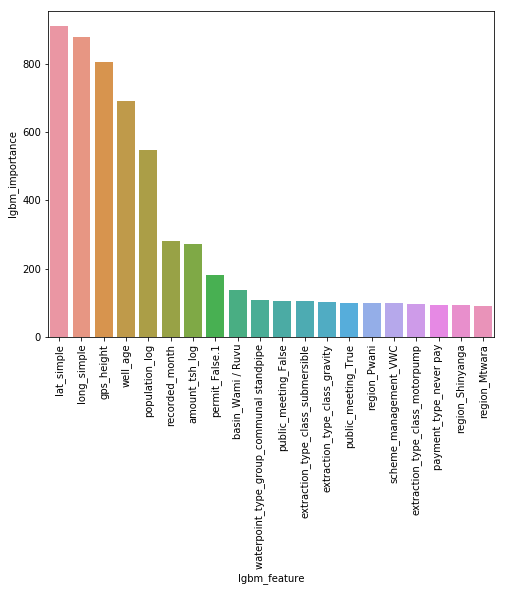

In [38]:
# Plot rf feature importance
# Set plot size
fig, ax = plt.subplots(figsize=(8, 6))

# Plot importance with correct lables
g = sns.barplot(data=lgbm_feature_importance, x='lgbm_feature', y='lgbm_importance')
g.set_xticklabels(lgbm_feature_importance.lgbm_feature, rotation=90);

The coordinates and gps_height scorce very high, this might be of concern since these values contain a handful of imputations, if we failed with these imputations our model and redid them, perhaps our model can excel further.

## KNN
K-Nearest Neighbors model. A simpler approach than random forest and LGBM.

In [50]:
# KNN requires scaled data 
# Scale train data
scaled_train_data = scale(train_data)

# Scale test data
scaled_test_data = scale(test_data)

In [51]:
# Split train_data into train(x) and validation(y) split -> use scaled data
s_train_features, s_validation_features, s_train_labels, s_validation_labels = \
    train_test_split(scaled_train_data, target_labels, test_size=0.30, random_state=42)

In [7]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)

# fitting the model
knn.fit(s_train_features, s_train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [8]:
# predict the response
knn_predicted = knn.predict(s_validation_features)
knn_accuracy = accuracy_score(s_validation_labels, knn_predicted)

print(f'Mean accuracy first KNN score: {knn_accuracy:.3}')

Mean accuracy KNN score: 0.749


In [11]:
# creating odd list of K for KNN
neighbors = [1, 3, 5, 7, 9]

# empty list that will hold cv scores
cv_scores = []

# perform 3-fold cross validation
for k in neighbors:
    # intilize model
    knn = KNeighborsClassifier(n_neighbors=k)
    # cross validate prediction accuracies
    scores = cross_val_score(knn, s_train_features, s_train_labels, cv=3, scoring='accuracy')
    # add cv score to cv scores
    cv_scores.append(scores.mean())

In [59]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining highest cv_score
highest_cv_score = max(cv_scores)
# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]

print("The optimal number of neighbors is %d with mean cv score: %.3f" % (optimal_k, highest_cv_score))

The optimal number of neighbors is 5 with mean cv score: 0.740


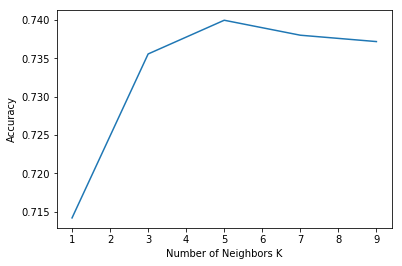

In [61]:
# plot misclassification error vs k
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.show()

In [122]:
# final knn model with best neighbor (k = 5)
final_knn = KNeighborsClassifier(n_neighbors=5)

# fitting the model
final_knn.fit(s_train_features, s_train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [123]:
# predict the response
knn_final_predicted = final_knn.predict(validation_features)
knn_final_accuracy = accuracy_score(s_validation_labels, s_knn_final_predicted)

#print(f'Mean accuracy first KNN score: {knn_accuracy:.3}')
print(f'Mean accuracy final KNN score: {knn_final_accuracy:.3}')

Mean accuracy final KNN score: 0.754


In [64]:
# Create confusion matrix
knn_confusion = pd.DataFrame(confusion_matrix(s_validation_labels, knn_final_predicted))
knn_confusion

,0,1,2
0,6925,989,184
1,1609,3969,100
2,603,202,269


Doesn't seem to give promising results, we move on. Perhaps the KNN is to simple to understand the rather complex relationship between data and targets.

###  LDA
Linear discriminant analysis based model. Finds a linear combination of features that characterizes or separates our targets. We also tried to use PCA for dimension reducation and use these to compare against LDA, and also use dimensions for LDA model. These results were far inferior and therefore were dropped. 

In [56]:
# define lda model
lda = LinearDiscriminantAnalysis()

# fitting model to pca data
lda.fit(s_train_features, s_train_labels)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [57]:
# predict the response
lda_predicted = lda.predict(s_validation_features)
lda_accuracy = accuracy_score(s_validation_labels, lda_predicted)

print(f'Mean accuracy first LDA score: {lda_accuracy:.3}')

Mean accuracy first LDA score: 0.731


In [58]:
pprint(lda.get_params())

{'n_components': None,
 'priors': None,
 'shrinkage': None,
 'solver': 'svd',
 'store_covariance': False,
 'tol': 0.0001}


Doesn't seem to give promising results, we move on. Similar to KNN, the complexity of relationships can not efficiently be reducued to lower dimensions.

### LogisticRegression -  One vs All Classifier

LogisticRegression with one vs all multiclass classification. Method to reduce multi-class problem into multiple binary problems.

In [63]:
# define lr model
lr_ova = LogisticRegressionCV(penalty='l1'
    , scoring='accuracy'
    , cv=3
    , random_state=42
    , max_iter=20
    , fit_intercept=True
    , solver='saga'
    , tol=20
    , multi_class = 'ovr')

# fitting the model
lr_ova.fit(s_train_features, s_train_labels)

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=20,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=42,
           refit=True, scoring='accuracy', solver='saga', tol=20,
           verbose=0)

In [64]:
# predict the response
lr_ova_predicted = lr_ova.predict(s_validation_features)
lr_ova_accuracy = accuracy_score(s_validation_labels, lr_ova_predicted)

print(f'Mean accuracy first lr_ova score: {lr_ova_accuracy:.3}')

Mean accuracy first lr_ova score: 0.734


Doesn't seem to give promising results, we move on. This bad result is probably due the our targets being unbalanced. There are not enough samples of class non-functional / repairs to conclusively understand when to classify a new samples. 

##  Stacking Models
In this section we will try to stack our best model and see if they can complement eachother and thereby product better predictions.

In [65]:
# Stacking classifer
# Define the method for meta classifing
# lgbm_class = lgb.LGBMClassifier() -> tested: not better
# rforest_class = RandomForestClassifier(n_estimators=100, random_state=42) -> tested: not better
lr = LogisticRegression()
clf1 = rf_pipeline_rand_cv.best_estimator_
clf2 = lgbm_pipeline_rand_cv.best_estimator_

# Define stacking classifier
sclf = StackingClassifier(classifiers=[clf1, clf2], 
                          meta_classifier=lr)

# Define name of models and stack classifier
labels = ['RandomForest', 'LightGBM', 'LRStack']

# Define classifer list
clf_list = [clf1, clf2, sclf]

In [66]:
# Assing empty lists for cross validation mean scores and std
clf_cv_mean = []
clf_cv_std = []

# Cross validate each model and plot average score
for clf, label in zip(clf_list, labels):
        
    scores = cross_val_score(clf, train_data, target_labels, cv=3, scoring='accuracy')
    print("Accuracy: %.3f (+/- %.3f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

Accuracy: 0.808 (+/- 0.000) [RandomForest]
Accuracy: 0.797 (+/- 0.001) [LightGBM]
Accuracy: 0.791 (+/- 0.000) [LRStack]


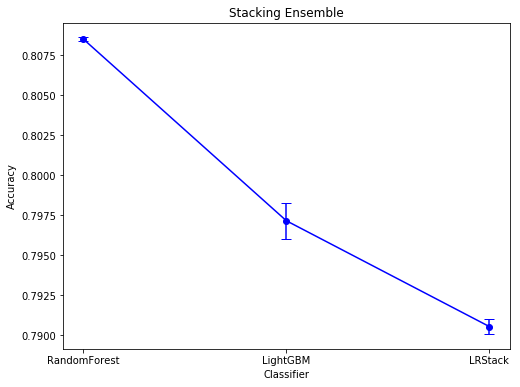

In [70]:
# Plot the accurancy of the different models
plt.figure(figsize=(8, 6))

(_, caps, _) = plt.errorbar(range(3), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)

for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                

plt.xticks(range(3), ['RandomForest', 'LightGBM', 'LRStack'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

The stacked model do not manage to do a better prediction than our the induvidual models. This is most likely due to both model having very similar way of predicting. The confusion matrices have the same pattern and therefore we get worse results as the meta classifier stuggles to determine what model to use for different instances. 

### Final Model
We have tried a range of model and conclude that the random forest is the best model and proceed to make a final submission based on this model.

In [71]:
# Fit model
rf_pipeline_rand_cv.best_estimator_.fit(train_data_np, target_labels_np)

Pipeline(memory=None,
     steps=[('feature_selection', SelectKBest(k=110, score_func=<function f_classif at 0x1a0fd12b70>)), ('my_classifier', RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=40, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [75]:
# Make predictions for test data, input into new df
final_predictions = pd.DataFrame(rf_pipeline_rand_cv.best_estimator_.predict(test_data_np))

## 10. Submission
Write prediction to submission.csv

In [76]:
# New df
submission = pd.DataFrame()

# Import id from test_data index
submission['id'] = test_data.index

# import status_group predictions 
submission['status_group'] = final_predictions

# convert numerical to description
submission.loc[submission.status_group == 0, 'status_group'] = 'functional'
submission.loc[submission.status_group == 1, 'status_group'] = 'non functional'
submission.loc[submission.status_group == 2, 'status_group'] = 'functional needs repair'

In [77]:
# Preview
submission.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [78]:
# Write submission to csv
submission.to_csv('submission_final.csv', sep=',', index=False)

### Conclusion
Our final submission scores 0.8162 on Data Driven, which places us within the top 500 on the leaderboard.
<br>

**Considerations**
<br>
To improve our score we should go back to data preporcessing and try to make better imputations for NaNs and incorrect values. Additionally, we can try to do more comprehensive feature engineering and thus find more information that can boost the predictive capability of our model.